In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
files = [
    ('results_qlearning', 'qlearning'),
    ('results_generative', 'optimal-generative'),
    ('results_eq6_model_free', 'eq6_model_free'),
    ('results_onpolicy', 'onpolicy'),
    ('results_eq6_model_based', 'eq6_model_based'),
    ('results_generative_with_constraints', 'optimal-with-nav-constraints'),
    ('results_onpolicy2', 'onpolicy2'),
    # ('results_onpolicy_model_based', 'onpolicy_model-based')
]

results = {}

for file_name, method in files:
    with open(f'{file_name}.pkl', 'rb') as f:
        results[method] = pickle.load(f)
results['onpolicy'][0].keys()

dict_keys(['num_visits_state', 'last_visit_state', 'policy_diff_generative', 'policy_diff_constraints', 'episode_rewards', 'episode_steps', 'greedy_rewards', 'greedy_steps', 'n_rows', 'n_cols', 'states_mapping'])

In [3]:
def process_data(data, keys):
    res = {}
    columns=  ['policy_diff_generative', 'policy_diff_constraints', 'episode_rewards', 'episode_steps', 'greedy_rewards', 'greedy_steps']
    for key in columns:
        iteration_episode_steps = []
        episode_steps = []
        for id in range(len(data)):
            iteration_episode_steps, temp = zip(*data[id][key])
            episode_steps.append(temp)
        episode_steps = np.array(episode_steps)
        
        res[key] = (iteration_episode_steps, episode_steps)
    return res

def compute_confidence(x, axis=0):
    z = np.array(x)
    mu = z.mean(axis)
    std = z.std(axis)
    N = z.shape[0]
    c = 1.96 * std / np.sqrt(N)
    return mu, mu - c, mu + c
        


/tmp/ipykernel_2208348/3041164814.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  episode_steps = np.array(episode_steps)


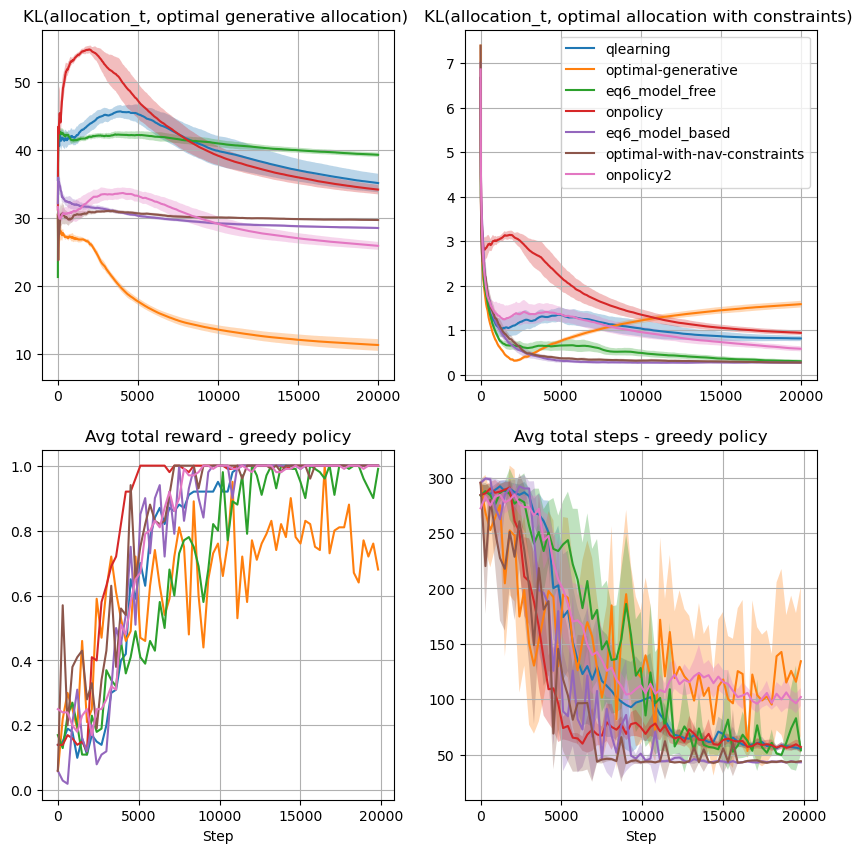

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
for file_name, method in files:
        
    data = process_data(results[method], results[method][0].keys())

    mu, lb, ub = compute_confidence(data['policy_diff_generative'][1])
    ax[0,0].plot(data['policy_diff_generative'][0], mu, label=method)
    ax[0,0].fill_between(data['policy_diff_generative'][0], lb, ub, alpha=0.3)
    ax[0,0].grid()
    ax[0,0].set_title('KL(allocation_t, optimal generative allocation) ')

    mu, lb, ub = compute_confidence(data['policy_diff_constraints'][1])
    ax[0,1].plot(data['policy_diff_constraints'][0], mu, label=method)
    ax[0,1].fill_between(data['policy_diff_constraints'][0], lb, ub, alpha=0.3)
    ax[0,1].grid()
    ax[0,1].set_title('KL(allocation_t, optimal allocation with constraints) ')


    mu, lb, ub = compute_confidence(data['greedy_rewards'][1])
    ax[1,0].plot(data['greedy_rewards'][0], mu, label=method)
    # ax[1,0].fill_between(data['greedy_rewards'][0], lb, ub, alpha=0.3)
    ax[1,0].grid()
    ax[1,0].set_xlabel('Step')
    ax[1,0].set_title('Avg total reward - greedy policy')


    mu, lb, ub = compute_confidence(data['greedy_steps'][1])
    ax[1,1].plot(data['greedy_steps'][0], mu, label=method)
    ax[1,1].fill_between(data['greedy_steps'][0], lb, ub, alpha=0.3)
    ax[1,1].grid()
    ax[1,1].set_xlabel('Step')
    ax[1,1].set_title('Avg total steps - greedy policy')

ax[0,1].legend()
plt.show()

In [5]:
results['qlearning'][0].keys()

dict_keys(['num_visits_state', 'last_visit_state', 'policy_diff_generative', 'policy_diff_constraints', 'episode_rewards', 'episode_steps', 'greedy_rewards', 'greedy_steps', 'n_rows', 'n_cols', 'states_mapping'])

/home/alessio/anaconda3/envs/maze-exploration/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


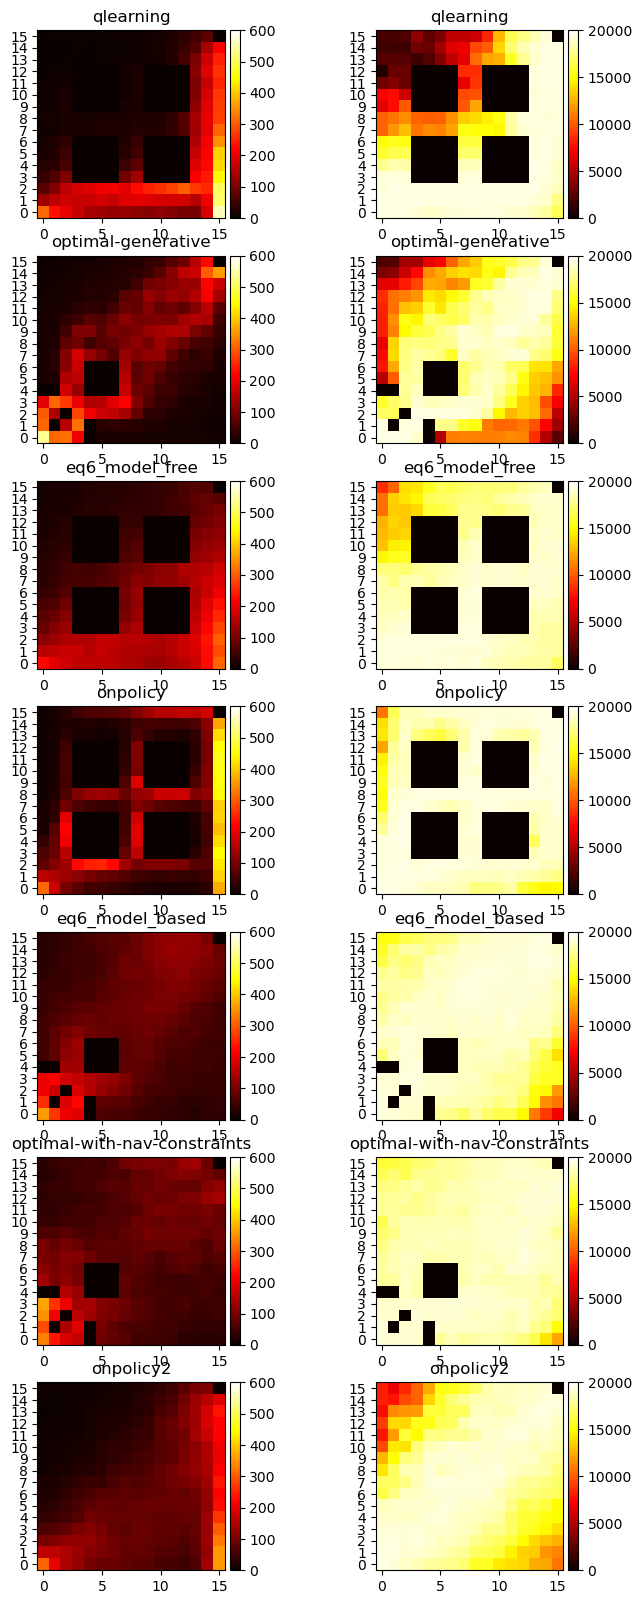

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import get_visits_matrix

fig, ax = plt.subplots(len(files), 2, figsize=(8, 20))

def plot_matrices(axis, method, key, vmax):
    
    n_rows = results[method][0]['n_rows']
    n_columns = results[method][0]['n_cols']
    states_mapping = results[method][0]['states_mapping']
    rows_labels = list(range(n_rows))
    rows_labels.reverse()



    N = len(results[method])
    freq_visits =[get_visits_matrix(n_rows, n_columns, states_mapping, results[method][x][key][-1][1]) for x in range(N)]
    freq_visits = np.array(freq_visits).mean(0)
    # vmax = np.max(freq_visits)
    im = axis.imshow(freq_visits, cmap='hot',vmin = 0, vmax = vmax)
    axis.set_yticks(np.arange(len(freq_visits)), labels=rows_labels)
    axis.set_title(f'{method}')
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

idx = 0
for file_name, method in files:
    plot_matrices(ax[idx,0], method, 'num_visits_state', 600)
    plot_matrices(ax[idx,1], method, 'last_visit_state', 20000)
    idx += 1

    # freq_visits =get_visits_matrix(n_rows, n_columns, states_mapping, results['qlearning'][0]['last_visit_state'][-1][1])
    # vmax = np.max(freq_visits)
    # im = ax[1].imshow(freq_visits, vmin = 0, vmax = vmax)
    # ax[1].set_yticks(np.arange(len(freq_visits)), labels=rows_labels)
    # ax[1].set_title('Frequency of visitation')
    # divider = make_axes_locatable(ax[1])
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # fig.colorbar(im, cax=cax)